In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [74]:
# 1. 加载生成器模型
generator = load_model('saved_models_1/best_generator.h5')

# 2. 定义生成参数
batch_size = 32
sequence_length = 120  # 每小时数据点数
num_features = 3
column_names = ['temperature_channel1', 'cooling_channel0', 'maxigauge_channel3']

# 3. 生成合成数据
noise = np.random.normal(size=(batch_size, sequence_length, num_features)).astype(np.float32)
synthetic_data = generator.predict(noise)
df_synthetic = pd.DataFrame(
    synthetic_data.reshape(-1, num_features),
    columns=column_names,
    dtype=np.float32
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


In [75]:
# 4. 定义异常注入器类
class EnhancedAnomalyInjector:
    def __init__(self, cooling_group, temp_group, maxigauge_group, physical_constraints=None, points_per_hour=120, min_spacing=10):
        self.cooling_group = cooling_group
        self.temp_group = temp_group
        self.maxigauge_group = maxigauge_group
        self.constraints = physical_constraints or {}
        self.points_per_hour = points_per_hour
        self.min_spacing = min_spacing

    def inject_anomalies(self, df, min_anomalies_per_hour=1, max_anomalies_per_hour=5, min_duration=1, max_duration=15, random_seed=None):
        if random_seed is not None:
            np.random.seed(random_seed)

        df_anomalous = df.copy()
        anomaly_indicator = np.zeros(len(df))
        total_points = len(df)
        n_hours = int(np.ceil(total_points / self.points_per_hour))
        anomalies_per_hour = np.random.randint(min_anomalies_per_hour, max_anomalies_per_hour + 1, size=n_hours)
        anomaly_types = ['shift', 'spike', 'noise', 'freeze', 'drift', 'compound']
        anomaly_probs = [0.25, 0.25, 0.2, 0.1, 0.1, 0.1]

        current_point = 0
        for hour_idx in range(n_hours):
            hour_start = current_point
            hour_end = min(current_point + self.points_per_hour, total_points)
            n_anomalies = anomalies_per_hour[hour_idx]
            candidates = np.arange(hour_start, hour_end - max_duration)

            valid_positions = []
            while len(valid_positions) < n_anomalies and len(candidates) > 0:
                candidate = np.random.choice(candidates)
                if all(abs(candidate - pos) >= self.min_spacing for pos in valid_positions):
                    valid_positions.append(candidate)
                    candidates = candidates[np.abs(candidates - candidate) >= self.min_spacing]
                else:
                    candidates = np.setdiff1d(candidates, [candidate])

            for pos in valid_positions:
                duration = np.random.randint(min_duration, max_duration + 1)
                end_pos = min(pos + duration, hour_end)
                anomaly_type = np.random.choice(anomaly_types, p=anomaly_probs)
                for t in range(pos, end_pos):
                    if anomaly_type == 'shift':
                        self._apply_shift(df_anomalous, t)
                    elif anomaly_type == 'spike':
                        self._apply_spike(df_anomalous, t)
                    elif anomaly_type == 'noise':
                        self._apply_noise(df_anomalous, t)
                    elif anomaly_type == 'freeze':
                        self._apply_freeze(df_anomalous, t)
                    elif anomaly_type == 'drift':
                        self._apply_drift(df_anomalous, t)
                    elif anomaly_type == 'compound':
                        self._apply_spike(df_anomalous, t)
                        self._apply_drift(df_anomalous, t)
                    self._validate_constraints(df_anomalous, t)
                    anomaly_indicator[t] = 1

            current_point = hour_end

        return df_anomalous, anomaly_indicator

    def _apply_shift(self, df, idx):
        group = np.random.choice(['cooling', 'temp', 'maxigauge', 'single'])
        if group == 'cooling':
            shift = np.random.uniform(-5, 5)
            for ch in self.cooling_group:
                df.at[idx, ch] += shift
        elif group == 'temp':
            shift = np.random.uniform(-10, 10)
            for ch in self.temp_group:
                df.at[idx, ch] += shift
        elif group == 'maxigauge':
            shift = np.random.uniform(-100, 100)
            for ch in self.maxigauge_group:
                df.at[idx, ch] += shift
        else:
            ch = np.random.choice(df.columns)
            if ch in self.cooling_group:
                df.at[idx, ch] += np.random.uniform(-5, 5)
            elif ch in self.temp_group:
                df.at[idx, ch] += np.random.uniform(-10, 10)
            else:
                df.at[idx, ch] += np.random.uniform(-100, 100)

    def _apply_spike(self, df, idx):
        ch = np.random.choice(df.columns)
        factor = np.random.choice([-1, 1])
        if ch in self.cooling_group or ch in self.temp_group:
            df.at[idx, ch] *= factor * np.random.uniform(2, 5)
        else:
            df.at[idx, ch] *= factor * np.random.uniform(2, 10)

    def _apply_noise(self, df, idx):
        ch = np.random.choice(df.columns)
        if ch in self.cooling_group:
            df.at[idx, ch] += np.random.normal(0, 2)
        elif ch in self.temp_group:
            df.at[idx, ch] += np.random.normal(0, 40)
        else:
            df.at[idx, ch] += np.random.normal(0, 150)

    def _apply_freeze(self, df, idx):
        ch = np.random.choice(df.columns)
        if idx > 0:
            df.at[idx, ch] = df.at[idx - 1, ch]

    def _apply_drift(self, df, idx):
        ch = np.random.choice(df.columns)
        direction = np.random.choice([-1, 1])
        if ch in self.cooling_group:
            df.at[idx, ch] += direction * np.random.uniform(0.1, 0.5)
        elif ch in self.temp_group:
            df.at[idx, ch] += direction * np.random.uniform(1, 5)
        else:
            df.at[idx, ch] += direction * np.random.uniform(10, 50)

    def _validate_constraints(self, df, idx):
        for ch in df.columns:
            if ch in self.constraints:
                val = df.at[idx, ch]
                df.at[idx, ch] = np.clip(val, self.constraints[ch]['min'], self.constraints[ch]['max'])

In [76]:
# 5. 创建异常注入器并注入
injector = EnhancedAnomalyInjector(
    cooling_group=['cooling_channel0'],
    temp_group=['temperature_channel1'],
    maxigauge_group=['maxigauge_channel3'],
    physical_constraints={
        'temperature_channel1': {'min': -50, 'max': 150},
        'cooling_channel0': {'min': 0, 'max': 100},
        'maxigauge_channel3': {'min': 0, 'max': 1000}
    }
)

df_with_anomalies, anomaly_labels = injector.inject_anomalies(
    df_synthetic,
    min_anomalies_per_hour=1,
    max_anomalies_per_hour=5,
    min_duration=1,
    max_duration=10,
    random_seed=42
)

/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_46060/237348428.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.261081811297901' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[idx, ch] *= factor * np.random.uniform(2, 5)
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_46060/237348428.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.56625398873772' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[idx, ch] += direction * np.random.uniform(10, 50)
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_46060/237348428.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.037530664020007' has dtype incompati

In [77]:
# 6. 重塑为原始形状
synthetic_data_with_anomalies = df_with_anomalies.values.reshape(batch_size, sequence_length, num_features)
anomaly_labels = anomaly_labels.reshape(batch_size, sequence_length)

✅ 成功注入异常
数据形状: (32, 120, 3)
异常比例: 14.32%


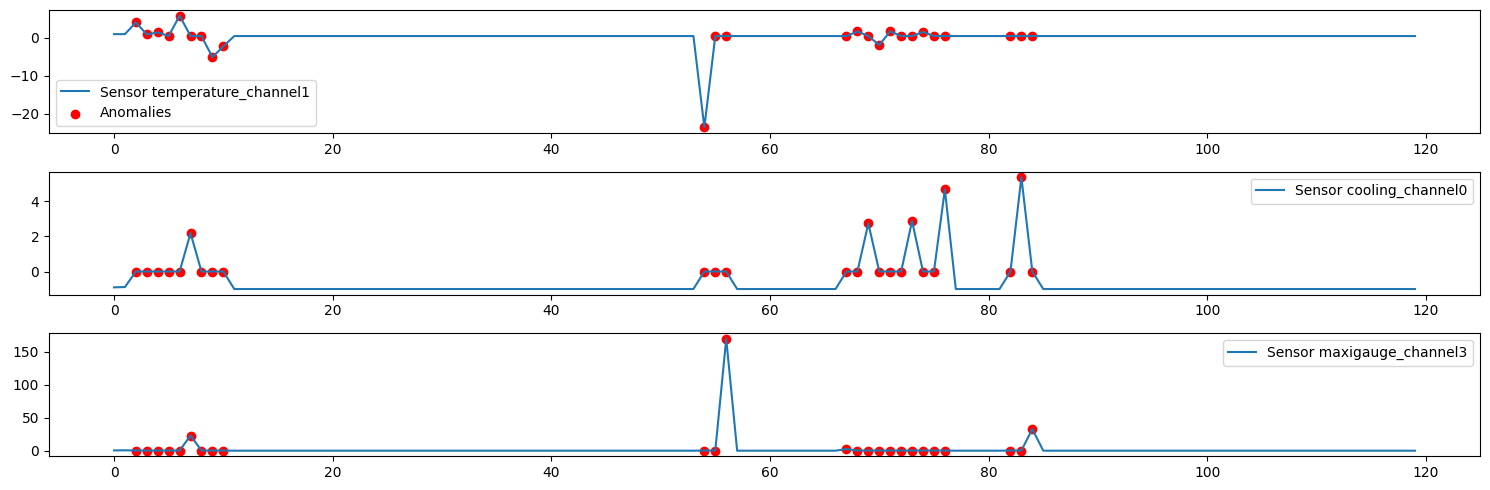

In [78]:
# 7. 输出信息与可视化
print("✅ 成功注入异常")
print(f"数据形状: {synthetic_data_with_anomalies.shape}")
print(f"异常比例: {anomaly_labels.mean():.2%}")

plt.figure(figsize=(15, 5))
for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.plot(synthetic_data_with_anomalies[0, :, i], label=f'Sensor {column_names[i]}')
    anomalies = np.where(anomaly_labels[0] == 1)[0]
    plt.scatter(anomalies, synthetic_data_with_anomalies[0, anomalies, i],
                color='red', label='Anomalies' if i == 0 else "")
    plt.legend()
plt.tight_layout()
plt.show()